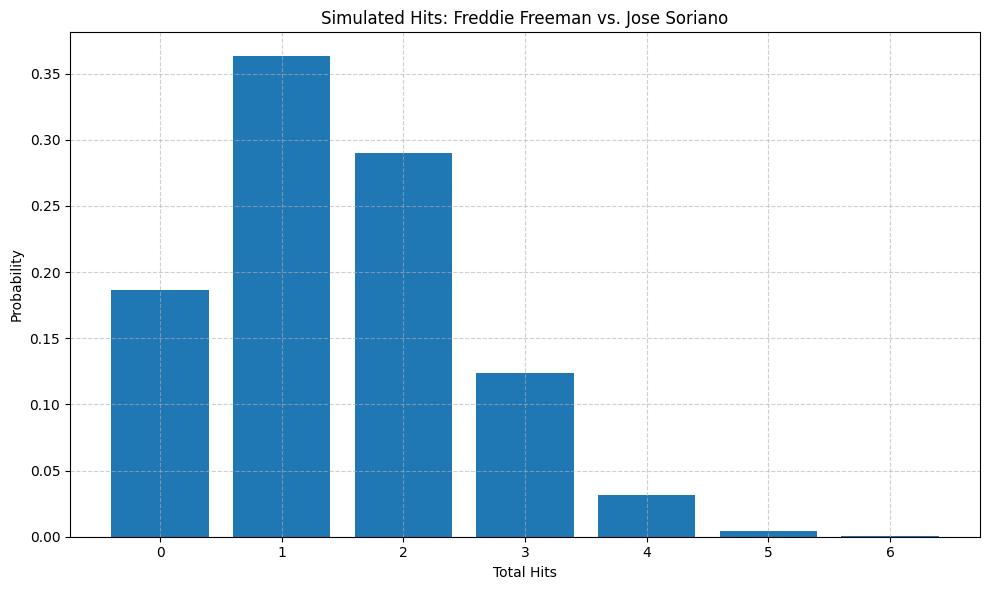


=== Monte Carlo summary: Freddie Freeman vs Jose Soriano ===
Trials: 10000 | Mean: 1.4664 | Std: 1.0612
P(0): 0.1867 | P(1+): 0.8133 | P(2+): 0.4503
over_0_5: 0.813300
over_1_5: 0.450300

=== Market pricing (Covers) ===
              book |               line |               side |               odds | market_no_vig_prob |    break_even_prob |         model_prob |               edge |           ev_per_$ |         kelly_frac |        kelly_stake |     recommendation
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
            Bet365 |                0.5 |               Over |                350 |           0.217391 |           0.222222 |             0.8133 |           0.591078 |            2.65985 |           0.379979 |            3799.79 |                BET
            Bet365 |         

In [2]:
# hits_market.py
import os, re, types, joblib, requests
from typing import Dict, Tuple, Optional, List, Union, Iterable
from collections import Counter, defaultdict
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import CategoricalNB

# Your own modules
import AtBatSim
from baseball_utils import *

# =========================
# Pack loading / model prep
# =========================

def _load_pack(path: str):
    return types.SimpleNamespace(**joblib.load(path))

def _build_models_from_pitcher_df(pitcher_pack):
    df = getattr(pitcher_pack, "pitcher_data_arch", None)
    if df is None or len(df) == 0:
        raise ValueError("pitcher_data_arch missing from pack. Re-export packs with include_full_df=True.")

    # --- Pitch (hybrid: lookup + NB) ---
    need_cols = ["stand_enc", "count_enc", "arch_enc", "pitch_cluster_enc"]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"pitcher_data_arch missing columns: {missing}")

    Xp = df[["stand_enc", "count_enc", "arch_enc"]].astype(int).values
    yp = df["pitch_cluster_enc"].astype(int).values

    pitch_lookup = defaultdict(Counter)
    for x, y in zip(Xp, yp):
        pitch_lookup[tuple(x)][int(y)] += 1
    nb_pitch = CategoricalNB().fit(Xp, yp)

    # --- Zone (hybrid: lookup + NB) ---
    dfz = df[df["zone"].notna() & df["zone"].isin(range(1, 15))].copy()
    dfz["zone_enc"] = dfz["zone"].astype(int) - 1
    Xz = dfz[["pitch_cluster_enc", "count_enc", "stand_enc"]].astype(int).values
    yz = dfz["zone_enc"].astype(int).values

    zone_lookup = defaultdict(Counter)
    for x, y in zip(Xz, yz):
        zone_lookup[tuple(x)][int(y)] += 1
    nb_zone = CategoricalNB().fit(Xz, yz)

    return nb_pitch, pitch_lookup, nb_pitch.classes_, nb_zone, zone_lookup, nb_zone.classes_

def _build_models_from_pitcher_name(pitcher_last_lower: str, packs_dir: str):
    pitcher = _load_pack(os.path.join(packs_dir, f"pitcher_{pitcher_last_lower.lower()}.joblib"))
    (nb_pitch_model, pitch_lookup_table, pitch_class_labels,
     nb_zone_model,  zone_lookup_table,  zone_class_labels) = _build_models_from_pitcher_df(pitcher)
    return pitcher, nb_pitch_model, pitch_lookup_table, pitch_class_labels, nb_zone_model, zone_lookup_table, zone_class_labels

def _load_hitter_by_name(hitter_last_lower: str, packs_dir: str):
    return _load_pack(os.path.join(packs_dir, f"hitter_{hitter_last_lower.lower()}.joblib"))

# =========================
# Simulation helpers
# =========================

def _round_to_thirds(ip: float) -> float:
    return round(ip * 3) / 3

def _outs_from_ip(ip: float) -> int:
    whole, frac = divmod(round(ip * 10), 10)
    return whole * 3 + (2 if frac == 2 else 1 if frac == 1 else 0)

def _simulate_reliever_innings(simulated_ip, is_hitter_home, hitter_win_pct, pitcher_win_pct):
    if not is_hitter_home:
        relief_ip = 9 - simulated_ip
    else:
        prob_not_hitting_9th = hitter_win_pct / (hitter_win_pct + pitcher_win_pct + 1e-9)
        hits_in_9th = np.random.random() > prob_not_hitting_9th
        relief_ip = 9 - simulated_ip if hits_in_9th else 8 - simulated_ip
    relief_ip = max(0.0, relief_ip)
    n = int(relief_ip); frac = relief_ip - n
    if 0.3 <= frac < 0.5: return n + 0.1
    if 0.5 <= frac < 0.7: return n + 0.2
    return float(n)

def _simulate_pen_bf(ip_needed: float, bf_per_out) -> int:
    outs_req = _outs_from_ip(ip_needed)
    if outs_req <= 0: return 0
    arr = np.asarray(bf_per_out, dtype=float)
    if arr.size == 0: return 0
    samples = np.random.choice(arr, size=outs_req, replace=True)
    if samples[-1] == 0.5:  # avoid lone DP tail
        while True:
            new = np.random.choice(arr, size=1)[0]
            if new != 0.5:
                samples[-1] = new
                break
    return int(samples.sum())

def _hitter_facing_relief(simulated_bf: int, lineup_spot: int, bp_bf_sim: int) -> int:
    next_spot = (simulated_bf % 9) + 1
    return sum(1 for i in range(bp_bf_sim) if ((next_spot + i - 1) % 9 + 1) == lineup_spot)

def _simulate_hits_in_extras(prob_extra_innings, is_hitter_home, hitter_spot,
                             total_bf_pre_extras, hitter_xba,
                             bf_per_out_dist, home_IP_extras, away_IP_extras):
    if np.random.rand() >= prob_extra_innings:
        return {'extra_happens': False, 'hits': 0}
    extras_pool = home_IP_extras if (not is_hitter_home) else away_IP_extras
    if not extras_pool:
        return {'extra_happens': True, 'hits': 0}

    extra_ip = float(np.random.choice(extras_pool))
    ip_int = int(extra_ip); ip_frac = extra_ip - ip_int
    if np.isclose(ip_frac, 0.33): extra_ip = ip_int + 0.1
    elif np.isclose(ip_frac, 0.67): extra_ip = ip_int + 0.2

    outs_needed = _outs_from_ip(extra_ip)
    if outs_needed <= 0:
        return {'extra_happens': True, 'hits': 0}

    arr = np.asarray(bf_per_out_dist, dtype=float)
    if arr.size == 0:
        total_bf = 0
    else:
        bf_samples = np.random.choice(arr, size=outs_needed, replace=True)
        while bf_samples[-1] == 0.5:
            bf_samples[-1] = np.random.choice(arr)
        total_bf = int(round(bf_samples.sum()))

    next_spot = (total_bf_pre_extras % 9) + 1
    mc_ab = sum(1 for i in range(total_bf) if ((next_spot + i - 1) % 9 + 1) == hitter_spot)
    hits = np.random.binomial(mc_ab, float(hitter_xba))
    return {'extra_happens': True, 'hits': int(hits)}

def _resolve_hitter_xba(hitter, fallback=0.300):
    tbl = getattr(hitter, "xba_lookup_table", None)
    if isinstance(tbl, dict) and "G" in tbl:
        g = tbl["G"].get(("__GLOBAL__",), None)
        if isinstance(g, dict) and g.get("n", 0) > 0:
            return float(g["sum"] / g["n"])
    if getattr(hitter, "global_bip_xba", None) is not None:
        return float(hitter.global_bip_xba)
    if getattr(hitter, "xba", None) is not None:
        return float(hitter.xba)
    return float(fallback)

# =========================
# Simulation + distribution
# =========================

def _simulate_total_hits(hitter, pitcher, num_trials,
                         nb_pitch_model, pitch_lookup_table, pitch_class_labels,
                         nb_zone_model,  zone_lookup_table,  zone_class_labels,
                         is_home=True):

    # simple static team wOBA table (can be replaced with your live one)
    team_woba = pd.DataFrame({
        "Team": ["CHC","NYY","TOR","LAD","ARI","BOS","DET","NYM","MIL","SEA",
                 "PHI","HOU","STL","ATH","ATL","SDP","TBR","BAL","MIN","MIA",
                 "TEX","CIN","SFG","CLE","LAA","WSN","KCR","PIT","CHW","COL"],
        "wOBA": [0.333,0.337,0.328,0.334,0.329,0.328,0.322,0.317,0.313,0.319,
                 0.323,0.318,0.312,0.323,0.311,0.307,0.316,0.314,0.312,0.309,
                 0.298,0.313,0.302,0.296,0.311,0.305,0.298,0.285,0.293,0.296]
    })
    team_to_abbr = {
        "Angels":"LAA","Astros":"HOU","Athletics":"OAK","Blue Jays":"TOR","Braves":"ATL","Brewers":"MIL",
        "Cardinals":"STL","Cubs":"CHC","Diamondbacks":"ARI","Dodgers":"LAD","Giants":"SFG","Guardians":"CLE",
        "Mariners":"SEA","Marlins":"MIA","Mets":"NYM","Nationals":"WSN","Orioles":"BAL","Padres":"SDP",
        "Phillies":"PHI","Pirates":"PIT","Rangers":"TEX","Rays":"TBR","Reds":"CIN","Red Sox":"BOS",
        "Rockies":"COL","Royals":"KCR","Tigers":"DET","Twins":"MIN","White Sox":"CWS","Yankees":"NYY"
    }

    hitter_abbr = team_to_abbr[hitter.team_name]
    team_woba_val = team_woba.loc[team_woba["Team"] == hitter_abbr, "wOBA"].values[0]

    IP_model = pitcher.IPLinReg
    BF_model = pitcher.poisson_model
    ip_sigma = float(pitcher.ip_std)

    xba  = _resolve_hitter_xba(hitter, fallback=0.300)
    spot = int(getattr(hitter, "most_recent_spot", 3) or 3)

    BF_PER_OUT = np.array(getattr(pitcher, "bf_per_out", []), dtype=float)
    if BF_PER_OUT.size == 0: BF_PER_OUT = np.array([1.0], dtype=float)
    HOME_EXTRAS = getattr(pitcher, "home_IP_extras", [])
    AWAY_EXTRAS = getattr(pitcher, "away_IP_extras", [])
    P_EXTRAS    = float(getattr(pitcher, "prob_extra_innings", 0.09) or 0.09)

    win_pct_dict = {
        hitter.team_name: float(getattr(hitter, "winning_pct_value", 0.5) or 0.5),
        pitcher.team:     float(getattr(pitcher,  "winning_pct_value", 0.5) or 0.5),
    }

    hit_results = []

    for _ in range(num_trials):
        # starter IP
        expected_ip  = float(IP_model.predict([[team_woba_val]])[0])
        simulated_ip = _round_to_thirds(np.random.normal(expected_ip, ip_sigma))
        simulated_ip = float(np.clip(simulated_ip, 0.0, 9.0))

        # starter BF
        expected_bf  = float(BF_model.predict(pd.DataFrame({"ip":[simulated_ip]}))[0])
        simulated_bf = int(np.random.poisson(expected_bf))

        # PA vs starter
        full_cycles = simulated_bf // 9
        remainder   = simulated_bf % 9
        pa_vs_sp    = full_cycles + (1 if spot <= remainder else 0)

        hits_vs_sp = 0
        for _ in range(pa_vs_sp):
            result, _log = AtBatSim.simulate_at_bat_between(
                hitter=hitter, pitcher=pitcher,
                nb_pitch_model=nb_pitch_model, pitch_lookup_table=pitch_lookup_table, pitch_class_labels=pitch_class_labels,
                nb_zone_model=nb_zone_model, zone_lookup_table=zone_lookup_table, zone_class_labels=zone_class_labels,
                verbose=False, verbose_audit=False
            )
            if result == "HIT":
                hits_vs_sp += 1

        # bullpen
        rel_ip   = _simulate_reliever_innings(simulated_ip, is_home,
                                              win_pct_dict[hitter.team_name],
                                              win_pct_dict[pitcher.team])
        bp_bf    = _simulate_pen_bf(rel_ip, BF_PER_OUT)
        pa_vs_rp = _hitter_facing_relief(simulated_bf, spot, bp_bf)
        hits_vs_rp = np.random.binomial(n=pa_vs_rp, p=xba)

        # extras
        extras = _simulate_hits_in_extras(
            prob_extra_innings=P_EXTRAS,
            is_hitter_home=is_home,
            hitter_spot=spot,
            total_bf_pre_extras=simulated_bf + bp_bf,
            hitter_xba=xba,
            bf_per_out_dist=BF_PER_OUT,
            home_IP_extras=HOME_EXTRAS,
            away_IP_extras=AWAY_EXTRAS
        )

        total_hits = hits_vs_sp + hits_vs_rp + extras["hits"]
        hit_results.append(int(total_hits))

    return hit_results

def _probs_from_results(results: Iterable[int], lines: Tuple[float,...] = (0.5, 1.5)) -> Dict[str, float]:
    arr = np.asarray(results, dtype=int)
    probs = {}
    for line in lines:
        threshold = int(np.floor(line) + 1)  # e.g., 0.5 -> 1, 1.5 -> 2
        key = f"over_{str(line).replace('.', '_')}"
        probs[key] = float((arr >= threshold).mean()) if arr.size else 0.0
    return probs

# =========================
# Odds utils / scraping
# =========================

def american_to_decimal(odds: float) -> float:
    return 1 + (odds / 100.0) if odds > 0 else 1 + (100.0 / abs(odds))

def implied_prob_from_american(odds: float) -> float:
    return 100.0 / (odds + 100.0) if odds > 0 else abs(odds) / (abs(odds) + 100.0)

def remove_vig_two_way(over_odds: float, under_odds: float):
    p_over = implied_prob_from_american(over_odds)
    p_under = implied_prob_from_american(under_odds)
    s = p_over + p_under
    return p_over / s, p_under / s

def break_even_prob(odds: float) -> float:
    return 1.0 / american_to_decimal(odds)

def kelly_fraction(p: float, odds: float, kelly_scale: float = 1.0) -> float:
    b = american_to_decimal(odds) - 1.0
    q = 1.0 - p
    f = (b * p - q) / b
    return max(0.0, f * kelly_scale)

def ev_per_dollar(p: float, odds: float) -> float:
    b = american_to_decimal(odds) - 1.0
    return p * b - (1.0 - p)

def _guess_book_name_from_node(node_text: str) -> Optional[str]:
    t = (node_text or "").strip()
    if not t:
        return None
    patterns = {
        r"draft\s*kings|dk": "DraftKings",
        r"fan\s*duel|fd": "FanDuel",
        r"bet\s*mgm": "BetMGM",
        r"caesars": "Caesars",
        r"pointsbet": "PointsBet",
        r"barstool": "Barstool",
        r"bet365": "Bet365",
        r"betriver[s]?": "BetRivers",
        r"unibet": "UniBet",
        r"wynnbet": "WynnBET",
        r"betr": "Betr",
    }
    t_low = t.lower()
    for pat, name in patterns.items():
        if re.search(pat, t_low):
            return name
    return None

def fetch_hits_odds_from_covers(player_id: int, slug: str) -> Dict[str, Dict[str, Union[int, str]]]:
    """
    Scrape hits O/U odds for a player from Covers and try to extract sportsbook.
    NOTE: Covers uses its *own* player IDs (NOT MLBAM IDs).
    """
    url = f"https://www.covers.com/sport/baseball/mlb/players/{player_id}/{slug}"
    headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127 Safari/537.36"}
    r = requests.get(url, headers=headers, timeout=12)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")

    page_text = re.sub(r"\s+", " ", soup.get_text(" ", strip=True))
    markets: Dict[str, Dict[str, Union[int, str]]] = {}

    for line_key in ["0.5", "1.5"]:
        over, under = None, None
        m = re.search(rf"o{re.escape(line_key)}\s*([+\-]?\d+).*?u{re.escape(line_key)}\s*([+\-]?\d+)", page_text, flags=re.IGNORECASE)
        if m:
            over, under = int(m.group(1)), int(m.group(2))
        else:
            m = re.search(rf"u{re.escape(line_key)}\s*([+\-]?\d+).*?o{re.escape(line_key)}\s*([+\-]?\d+)", page_text, flags=re.IGNORECASE)
            if m:
                under, over = int(m.group(1)), int(m.group(2))
        if over is not None and under is not None:
            markets[line_key] = {"over": over, "under": under, "book": "Consensus/Unknown"}

    # Try to detect a sportsbook brand
    candidate_texts: List[str] = []
    for img in soup.find_all("img"):
        alt = (img.get("alt") or "").strip()
        if alt:
            candidate_texts.append(alt)
    for tag in soup.find_all(True):
        for attr in ["aria-label", "title", "data-partner", "data-sportsbook", "data-brand"]:
            val = tag.get(attr)
            if val:
                candidate_texts.append(str(val))
        cls = tag.get("class")
        if cls:
            candidate_texts.extend([str(c) for c in cls])
        txt = tag.get_text(strip=True)
        if txt and len(txt) <= 40:
            candidate_texts.append(txt)

    book_name = None
    for t in candidate_texts:
        book_name = _guess_book_name_from_node(t)
        if book_name:
            break
    if book_name:
        for v in markets.values():
            v["book"] = book_name

    return markets

def evaluate_hits_market_table(
    model_probs: Dict[str, float],
    market: Dict[str, Dict[str, Union[int, str]]],
    bankroll: float,
    kelly_scale: float = 0.5,
    min_edge: float = 0.0,
) -> List[dict]:
    rows: List[dict] = []
    for line, entry in market.items():
        if isinstance(entry, (tuple, list)):
            over_odds, under_odds = int(entry[0]), int(entry[1])
            book = "Consensus/Unknown"
        else:
            over_odds = int(entry["over"])
            under_odds = int(entry["under"])
            book = str(entry.get("book", "Consensus/Unknown"))

        key = f"over_{line.replace('.', '_')}"
        if key not in model_probs:
            continue

        p_over = float(model_probs[key])
        p_under = 1.0 - p_over

        p_over_nv, p_under_nv = remove_vig_two_way(over_odds, under_odds)
        be_over  = break_even_prob(over_odds)
        be_under = break_even_prob(under_odds)

        ev_over  = ev_per_dollar(p_over, over_odds)
        ev_under = ev_per_dollar(p_under, under_odds)
        k_over   = kelly_fraction(p_over, over_odds,  kelly_scale)
        k_under  = kelly_fraction(p_under, under_odds, kelly_scale)

        rows.append({
            "book": book, "line": line, "side": "Over", "odds": over_odds,
            "market_no_vig_prob": round(p_over_nv, 6),
            "break_even_prob": round(be_over, 6),
            "model_prob": round(p_over, 6),
            "edge": round(p_over - be_over, 6),
            "ev_per_$": round(ev_over, 6),
            "kelly_frac": round(k_over, 6),
            "kelly_stake": round(bankroll * k_over, 2),
            "recommendation": "BET" if (p_over - be_over) >= min_edge and ev_over > 0 else "PASS",
        })
        rows.append({
            "book": book, "line": line, "side": "Under", "odds": under_odds,
            "market_no_vig_prob": round(p_under_nv, 6),
            "break_even_prob": round(be_under, 6),
            "model_prob": round(p_under, 6),
            "edge": round(p_under - be_under, 6),
            "ev_per_$": round(ev_under, 6),
            "kelly_frac": round(k_under, 6),
            "kelly_stake": round(bankroll * k_under, 2),
            "recommendation": "BET" if (p_under - be_under) >= min_edge and ev_under > 0 else "PASS",
        })
    return rows

def _print_hits_table(rows: List[dict]) -> None:
    if not rows:
        print("No markets evaluated.")
        return
    cols = ["book","line","side","odds","market_no_vig_prob","break_even_prob","model_prob","edge","ev_per_$","kelly_frac","kelly_stake","recommendation"]
    header = " | ".join(f"{c:>18}" for c in cols)
    print(header)
    print("-"*len(header))
    for r in rows:
        print(" | ".join(f"{str(r[c]):>18}" for c in cols))

# =========================
# ONE public function
# =========================

def price_hits_market(
    hitter: Union[str, types.SimpleNamespace],
    pitcher: Union[str, types.SimpleNamespace],
    *,
    num_trials: int = 10000,
    packs_dir: str = "packs",
    covers_player_id: Optional[int] = None,   # Covers' internal ID (NOT MLBAM)
    covers_slug: Optional[str] = None,        # e.g., "freddie-freeman"
    lines: Tuple[float, ...] = (0.5, 1.5),
    bankroll: float = 10_000.0,
    kelly_scale: float = 0.5,
    min_edge: float = 0.00,
    show_plot: bool = True,
    print_summary: bool = True,
):
    """
    Run Monte Carlo for hitter vs pitcher, convert to O/U probabilities, scrape Covers odds,
    price the market, print outputs, and return artifacts.

    `hitter` / `pitcher` can be either:
      - a last-name string used to load packs from `packs_dir` (expects files:
        packs/hitter_<last>.joblib and packs/pitcher_<last>.joblib), OR
      - an already loaded SimpleNamespace pack.

    Returns:
      {
        "results": List[int],
        "probs": Dict[str, float],
        "market": Dict[str, Dict[str, Union[int,str]]],
        "table": List[dict],
        "hitter_pack": SimpleNamespace,
        "pitcher_pack": SimpleNamespace
      }
    """
    # Load packs if strings were provided
    if isinstance(hitter, str):
        hitter_pack = _load_hitter_by_name(hitter, packs_dir)
    else:
        hitter_pack = hitter

    if isinstance(pitcher, str):
        (pitcher_pack,
         nb_pitch_model, pitch_lookup_table, pitch_class_labels,
         nb_zone_model,  zone_lookup_table,  zone_class_labels) = _build_models_from_pitcher_name(pitcher, packs_dir)
    else:
        pitcher_pack = pitcher
        (nb_pitch_model, pitch_lookup_table, pitch_class_labels,
         nb_zone_model,  zone_lookup_table,  zone_class_labels) = _build_models_from_pitcher_df(pitcher_pack)

    # Sanity checks (fail loud if bad packs)
    for obj, name, attrs in [
        (hitter_pack, "hitter", ["stand_encoder","outcome_encoder","cluster_encoder",
                                 "nb_outcome_model","outcome_lookup_table","outcome_class_labels",
                                 "xba_lookup_table","arch_enc","full_upper","team_name","xba","most_recent_spot"]),
        (pitcher_pack, "pitcher", ["pitcher_data_arch","IPLinReg","poisson_model","ip_std","team","winning_pct_value"])
    ]:
        missing = [a for a in attrs if getattr(obj, a, None) is None]
        if missing:
            raise RuntimeError(f"Pack '{name}' missing required attrs: {missing}")

    # Monte Carlo
    results = _simulate_total_hits(
        hitter=hitter_pack, pitcher=pitcher_pack, num_trials=num_trials,
        nb_pitch_model=nb_pitch_model, pitch_lookup_table=pitch_lookup_table, pitch_class_labels=pitch_class_labels,
        nb_zone_model=nb_zone_model, zone_lookup_table=zone_lookup_table, zone_class_labels=zone_class_labels,
        is_home=True
    )

    # Distribution → probabilities
    probs = _probs_from_results(results, lines=lines)

    # Optional plot
    if show_plot:
        hit_counts = Counter(results)
        max_hits = max(hit_counts.keys()) if hit_counts else 0
        empirical_pdf = [hit_counts.get(i, 0) / len(results) for i in range(max_hits + 1)] if results else [1.0]
        plt.figure(figsize=(10, 6))
        plt.bar(range(max_hits + 1), empirical_pdf)
        plt.title(f"Simulated Hits: {hitter_pack.full_upper} vs. {pitcher_pack.full_upper}")
        plt.xlabel("Total Hits")
        plt.ylabel("Probability")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    # Odds from Covers (optional)
    market = {}
    if covers_player_id is not None and covers_slug:
        try:
            market = fetch_hits_odds_from_covers(player_id=int(covers_player_id), slug=str(covers_slug))
        except Exception as e:
            print(f"[warn] Covers scrape failed: {e}")

    # Price table
    table = []
    if market:
        table = evaluate_hits_market_table(
            model_probs=probs,
            market=market,
            bankroll=bankroll,
            kelly_scale=kelly_scale,
            min_edge=min_edge
        )

    # Print summary
    if print_summary:
        arr = np.asarray(results)
        mean = float(arr.mean()) if arr.size else 0.0
        std  = float(arr.std(ddof=1)) if arr.size > 1 else 0.0
        p0   = float((arr == 0).mean()) if arr.size else 1.0
        p1p  = float((arr >= 1).mean()) if arr.size else 0.0
        p2p  = float((arr >= 2).mean()) if arr.size else 0.0

        print(f"\n=== Monte Carlo summary: {hitter_pack.full_upper} vs {pitcher_pack.full_upper} ===")
        print(f"Trials: {len(results)} | Mean: {mean:.4f} | Std: {std:.4f}")
        print(f"P(0): {p0:.4f} | P(1+): {p1p:.4f} | P(2+): {p2p:.4f}")
        for k in sorted(probs):
            print(f"{k}: {probs[k]:.6f}")

        if market:
            print("\n=== Market pricing (Covers) ===")
            _print_hits_table(table)
        else:
            print("\n(no Covers market found or provided; skipped pricing table)")

    return {
        "results": results,
        "probs": probs,
        "market": market,
        "table": table,
        "hitter_pack": hitter_pack,
        "pitcher_pack": pitcher_pack,
    }





#from hits_market import price_hits_market

# Example: run in one line (with Covers pricing)
out = price_hits_market(
    hitter="freeman",        # or pass the loaded hitter pack object
    pitcher="soriano",       # or pass the loaded pitcher pack object
    num_trials=10000,
    packs_dir="packs",
    covers_player_id=14210,     # NOTE: Covers' own ID, not MLBAM
    covers_slug="freddie-freeman",
    lines=(0.5, 1.5),
    bankroll=10000,
    kelly_scale=0.5,
    min_edge=0.00,
    show_plot=True,
    print_summary=True
)

# Access artifacts programmatically if you need:
results = out["results"]
probs   = out["probs"]
table   = out["table"]